# Import and global variable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
import datetime
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print(datetime.datetime.now())
print(now)

2020-06-20 08:10:04.725985
20200620_081004


In [3]:
xl_writer = pd.ExcelWriter(f"covid19_world_data_{now}.xlsx")

# Data

data from https://github.com/CSSEGISandData/COVID-19

or

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

# Cases

In [4]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [5]:
df = pd.read_csv(url)

In [6]:
df.to_excel(xl_writer, "raw")

In [7]:
df.drop(columns=['Lat', 'Long'], inplace=True)

In [8]:
df.head()

Province/State Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
0            NaN    Afghanistan        0        0        0        0        0   
1            NaN        Albania        0        0        0        0        0   
2            NaN        Algeria        0        0        0        0        0   
3            NaN        Andorra        0        0        0        0        0   
4            NaN         Angola        0        0        0        0        0   

   1/27/20  1/28/20  1/29/20  ...  6/10/20  6/11/20  6/12/20  6/13/20  \
0        0        0        0  ...    22142    22890    23546    24102   
1        0        0        0  ...     1341     1385     1416     1464   
2        0        0        0  ...    10484    10589    10698    10810   
3        0        0        0  ...      852      852      853      853   
4        0        0        0  ...      113      118      130      138   

   6/14/20  6/15/20  6/16/20  6/17/20  6/18/20  6/19/20  
0    24766    25527    26310    26874    27532    27878  
1     1521     1590     1672     1722     1788     1838  
2    10919    11031    11147    11268    11385    11504  
3      853      853      854      854      855      855  
4      140      142      148      155      166      172  

[5 rows x 152 columns]

In [9]:
countries = df["Country/Region"].unique()

In [10]:
countries.sort()

In [11]:
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [12]:
province = df["Province/State"]

In [13]:
province.dropna(inplace=True)

In [14]:
province = province.unique()

In [15]:
province.sort()

In [16]:
province

array(['Alberta', 'Anguilla', 'Anhui', 'Aruba',
       'Australian Capital Territory', 'Beijing', 'Bermuda',
       'Bonaire, Sint Eustatius and Saba', 'British Columbia',
       'British Virgin Islands', 'Cayman Islands', 'Channel Islands',
       'Chongqing', 'Curacao', 'Diamond Princess',
       'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guiana',
       'French Polynesia', 'Fujian', 'Gansu', 'Gibraltar',
       'Grand Princess', 'Greenland', 'Guadeloupe', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Isle of Man',
       'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Manitoba',
       'Martinique', 'Mayotte', 'Montserrat', 'New Brunswick',
       'New Caledonia', 'New South Wales', 'Newfoundland and Labrador',
       'Ningxia', 'Northern Territory', 'Northwest Territories',
       'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Qinghai',
       'Quebec', 'Queensland

In [17]:
def extract_data(data_frame, country, region=None, groupby=False):
    if groupby:
        s = data_frame[data_frame["Country/Region"] == country].groupby(by=["Country/Region",]).sum().stack().droplevel(level=0)
    else:
        d = data_frame[(data_frame["Country/Region"] == country)]
        if region:
            s = d[d["Province/State"] == region].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)
        else:
            s = d[d["Province/State"].isna()].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)
    s.index = pd.to_datetime(s.index)
    df = s.to_frame()
    if region:
        df.columns = [region,]
    else:
        df.columns = [country,]
    df["day_of_year"] = df.index.dayofyear
    df.reset_index(inplace=True)
    df.columns = ['date'] + list(df.columns[1:])
    return df.set_index(['date', 'day_of_year'])

In [18]:
def plot_data(dataframe, logx=False, logy=False, **kwargs):
    if logx:
        df = dataframe.reset_index(level=0, drop=True)
        ax = df.plot(logx=logx, logy=logy, **kwargs)
    else:
        df = dataframe.reset_index(level=1, drop=True)
        ax = df.plot(logy=logy, **kwargs)
    return ax

In [19]:
def add(df1, df2, country):
    try:
        df = pd.concat([extract_data(df1, country), extract_data(df2, country)], axis=1)
    except KeyError:
        df = pd.concat([df1, df2], axis=1)
    df.country = country
    df.columns = ["cases", "deaths"]
    df["daily_cases"] = df["cases"].diff()
    df.loc[df["daily_cases"].isna(), "daily_cases"] = 0
    df["daily_cases_s"] = signal.savgol_filter(df["cases"], 11, 3, deriv=1)
    df["daily_death"] = df["deaths"].diff()
    df.loc[df["daily_death"].isna(), "daily_death"] = 0
    df["daily_death_s"] = signal.savgol_filter(df["deaths"], 11, 3, deriv=1)
    return df

In [20]:
def plot_daily(data):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 13))
    dataframe = data.copy()
    dataframe.reset_index("day_of_year", drop=True, inplace=True)
    dataframe["cases"].plot(color="r", 
                            title=f"Cases in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax1)
    dataframe["daily_cases"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax1)  
    dataframe["daily_cases_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax1)
    #
    dataframe["deaths"].plot(color="r", 
                            title=f"Deaths in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax2)
    dataframe["daily_death"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax2)  
    dataframe["daily_death_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax2)


# Switzerland

In [21]:
swiss = extract_data(df, "Switzerland")

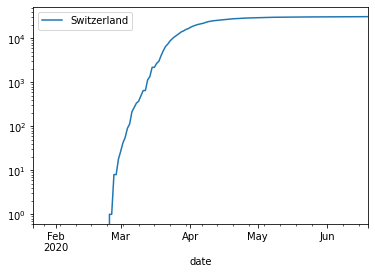

In [22]:
plot_data(swiss, logy=True)

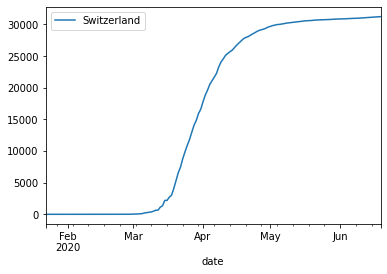

In [23]:
plot_data(swiss)

# Europe

In [24]:
italy = extract_data(df, "Italy")

In [25]:
france = extract_data(df, "France")

In [26]:
uk = extract_data(df, "United Kingdom")

In [27]:
spain = extract_data(df, "Spain")

In [28]:
germany =  extract_data(df, "Germany")

In [29]:
austria =  extract_data(df, "Austria")

In [30]:
europe = pd.concat([swiss, italy, france, germany, austria, spain, uk], axis=1)

In [31]:
# europe.columns = ['Switzerland', 'Italy', 'France', 'Germany', 'Austria', 'Spain', 'UK']

In [32]:
europe

Switzerland   Italy  France  Germany  Austria   Spain  \
date       day_of_year                                                          
2020-01-22 22                     0       0       0        0        0       0   
2020-01-23 23                     0       0       0        0        0       0   
2020-01-24 24                     0       0       2        0        0       0   
2020-01-25 25                     0       0       3        0        0       0   
2020-01-26 26                     0       0       3        0        0       0   
...                             ...     ...     ...      ...      ...     ...   
2020-06-15 167                31131  237290  189670   187682    17135  244109   
2020-06-16 168                31154  237500  189595   188252    17189  244328   
2020-06-17 169                31187  237828  189906   188604    17203  244683   
2020-06-18 170                31200  238159  190107   189817    17223  245268   
2020-06-19 171                31235  238011  190676   190299    17271  245575   

                        United Kingdom  
date       day_of_year                  
2020-01-22 22                        0  
2020-01-23 23                        0  
2020-01-24 24                        0  
2020-01-25 25                        0  
2020-01-26 26                        0  
...                                ...  
2020-06-15 167                  296857  
2020-06-16 168                  298136  
2020-06-17 169                  299251  
2020-06-18 170                  300469  
2020-06-19 171                  301815  

[150 rows x 7 columns]

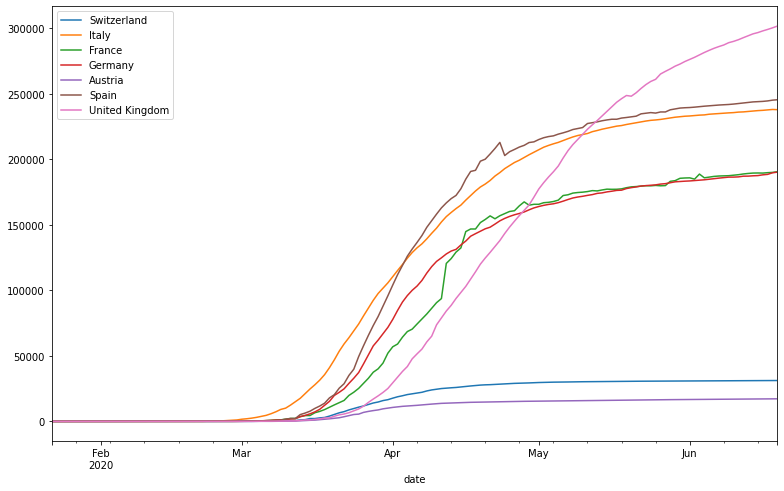

In [33]:
plot_data(europe, figsize=(13, 8))

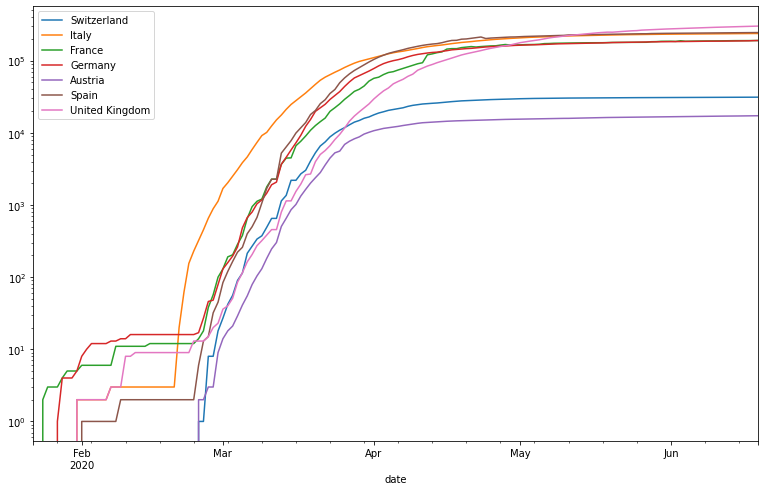

In [34]:
plot_data(europe, logy=True, figsize=(13, 8))

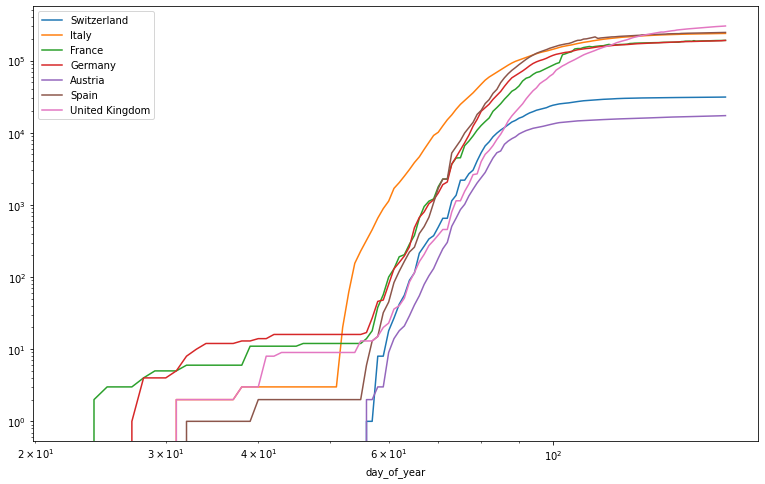

In [35]:
plot_data(europe, logy=True, logx=True, figsize=(13, 8))

# USA

In [36]:
us = extract_data(df, country="US", groupby=True)

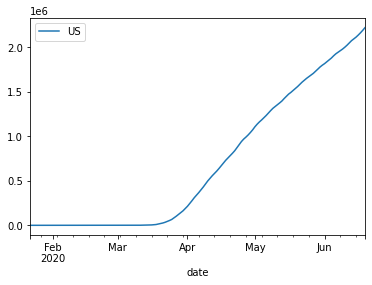

In [37]:
plot_data(us)

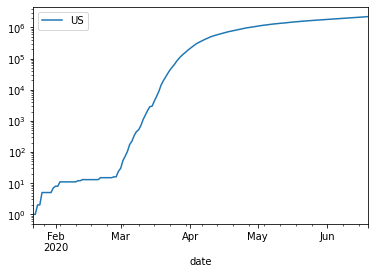

In [38]:
plot_data(us, logy=True)

# Europe + USA

In [39]:
comp_us = pd.concat([europe, us], axis=1)

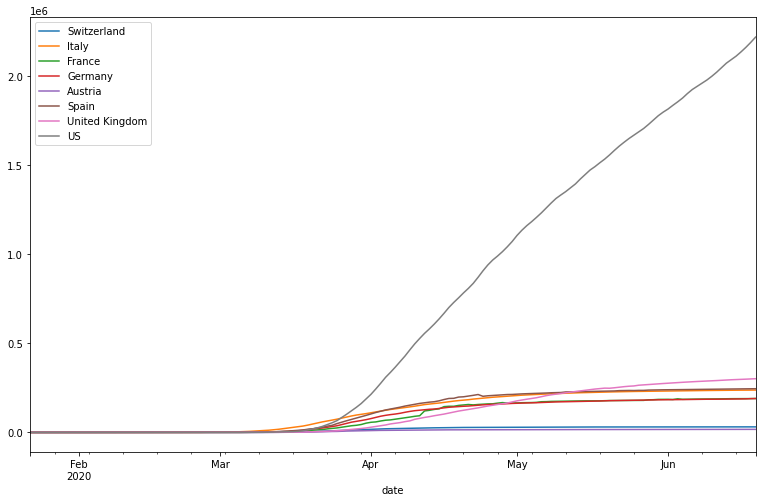

In [40]:
plot_data(comp_us, figsize=(13, 8))

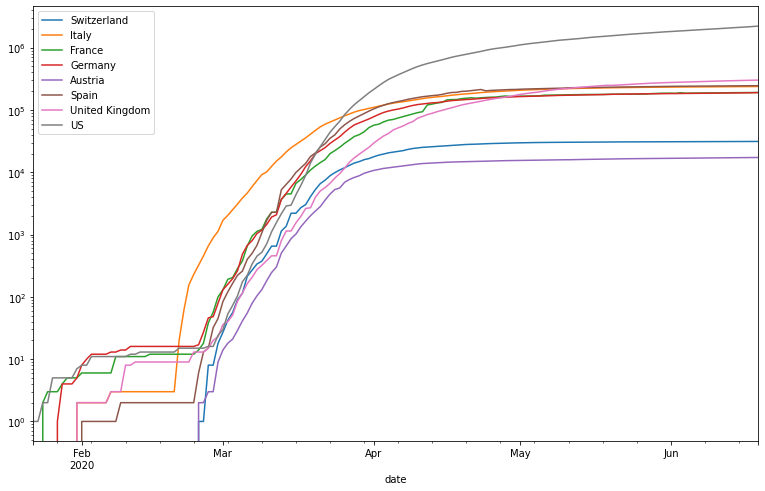

In [41]:
plot_data(comp_us, logy=True, figsize=(13, 8))

# Worldwide

In [42]:
world = df.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [43]:
world.index = pd.to_datetime(world.index)

In [44]:
world["day_of_year"] = world.index.dayofyear

In [45]:
world.reset_index(inplace=True)

In [46]:
world.columns = ["date", "world_cases", "day_of_year"]

In [47]:
world.set_index(["date", "day_of_year"], inplace=True)

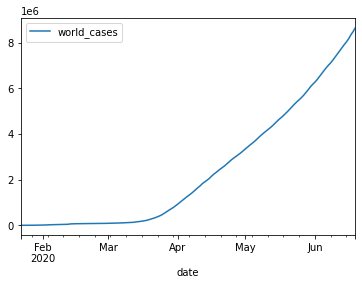

In [48]:
plot_data(world)

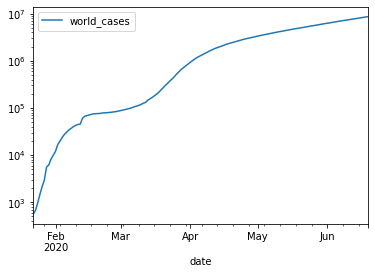

In [49]:
plot_data(world, logy=True)

# Iran

In [50]:
iran = extract_data(df, "Iran")

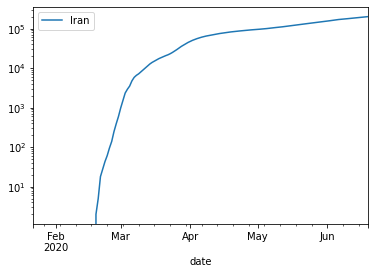

In [51]:
plot_data(iran, logy=True)

In [52]:
comp_iran = pd.concat([comp_us, iran], axis=1)

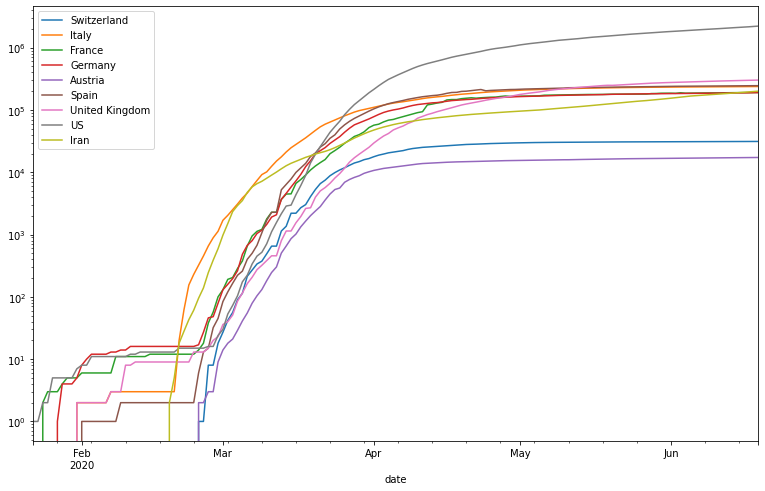

In [53]:
plot_data(comp_iran, logy=True, figsize=(13, 8))

# China

In [54]:
china = extract_data(df, "China", groupby=True)

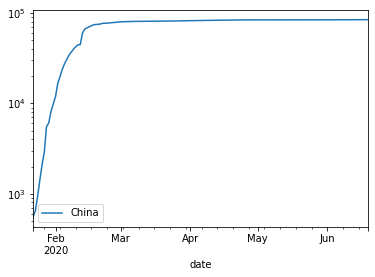

In [55]:
plot_data(china, logy=True)

In [56]:
comp_china = pd.concat([china, comp_us], axis=1)

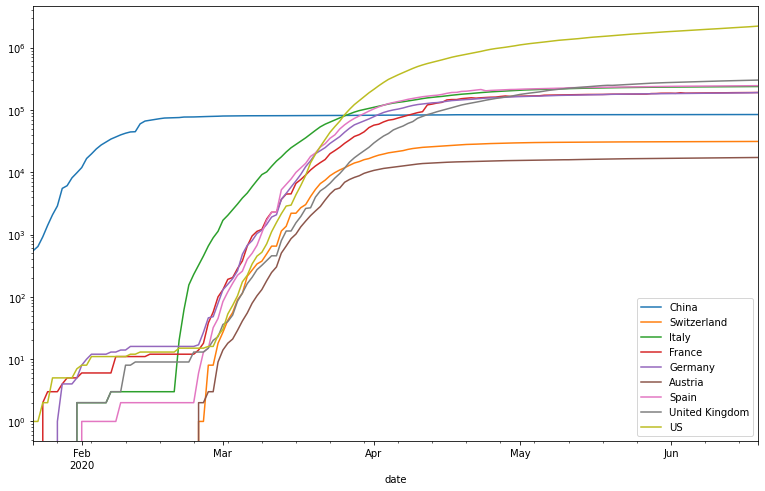

In [57]:
plot_data(comp_china, logy=True, figsize=(13, 8))

# Shanghai

In [58]:
shanghai = extract_data(df, "China", "Shanghai")

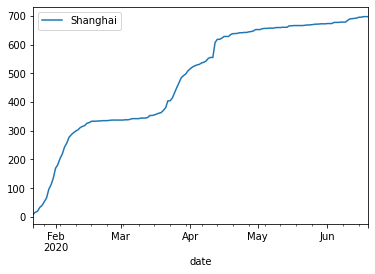

In [59]:
plot_data(shanghai)

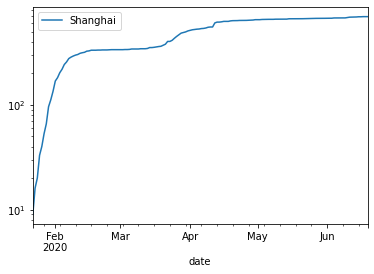

In [60]:
plot_data(shanghai, logy=True)

# Singapore

In [61]:
singapore = extract_data(df, "Singapore")

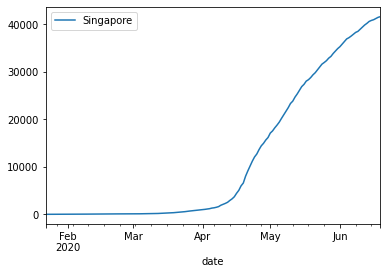

In [62]:
plot_data(singapore)

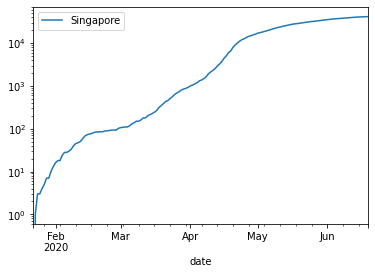

In [63]:
plot_data(singapore, logy=True)

# South Korea

In [64]:
kr = extract_data(df, "Korea, South")

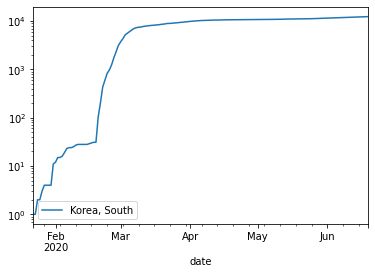

In [65]:
plot_data(kr, logy=True)

# South Central China

## Hong Kong

In [66]:
hong_kong = extract_data(df,"China", "Hong Kong")

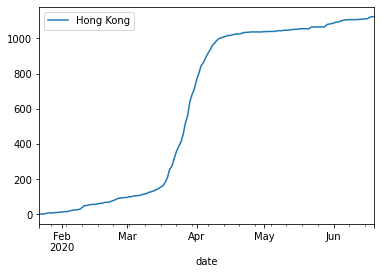

In [67]:
plot_data(hong_kong)

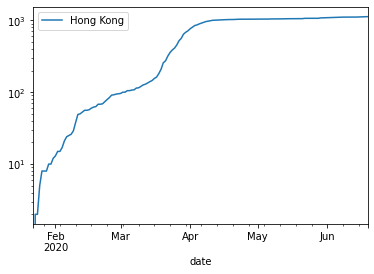

In [68]:
plot_data(hong_kong, logy=True)

## Hubei (Wuhan)

In [69]:
hubei = extract_data(df,"China", "Hubei")

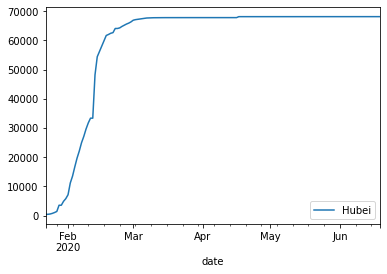

In [70]:
plot_data(hubei)

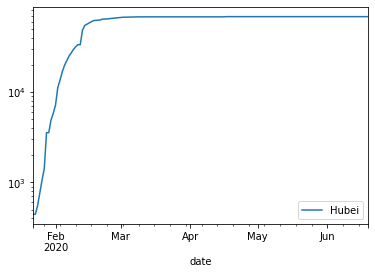

In [71]:
plot_data(hubei, logy=True)

## Henan

In [72]:
henan = extract_data(df, "China", "Henan")

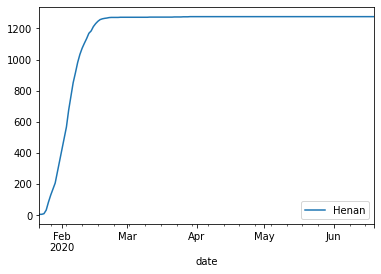

In [73]:
plot_data(henan)

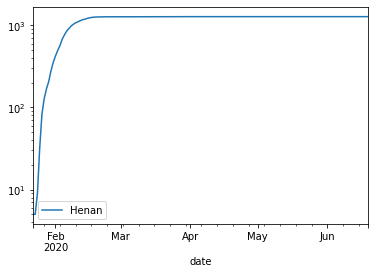

In [74]:
plot_data(henan, logy=True)

## Hunan

In [75]:
hunan = extract_data(df, "China", "Hunan")

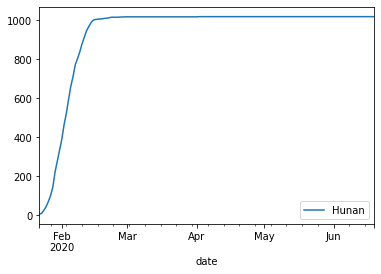

In [76]:
plot_data(hunan)

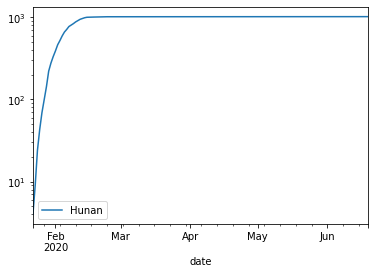

In [77]:
plot_data(hunan, logy=True)

## Guangdong

In [78]:
guangdong = extract_data(df, "China", "Guangdong")

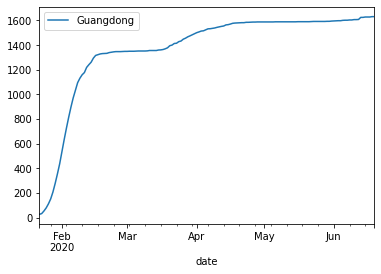

In [79]:
plot_data(guangdong)

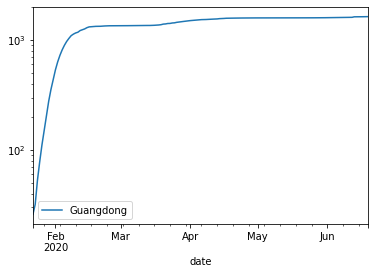

In [80]:
plot_data(guangdong, logy=True)

## Guangxi

In [81]:
guangxi = extract_data(df, "China", "Guangxi")

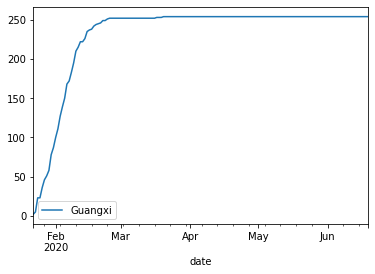

In [82]:
plot_data(guangxi)

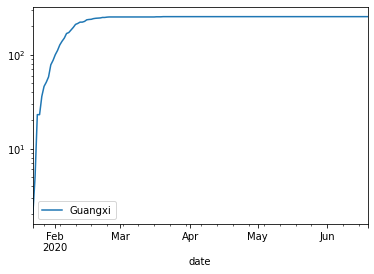

In [83]:
plot_data(guangxi, logy=True)

# South-Asia

In [84]:
south_asia = pd.concat([singapore, hong_kong, shanghai, kr, italy], axis=1)

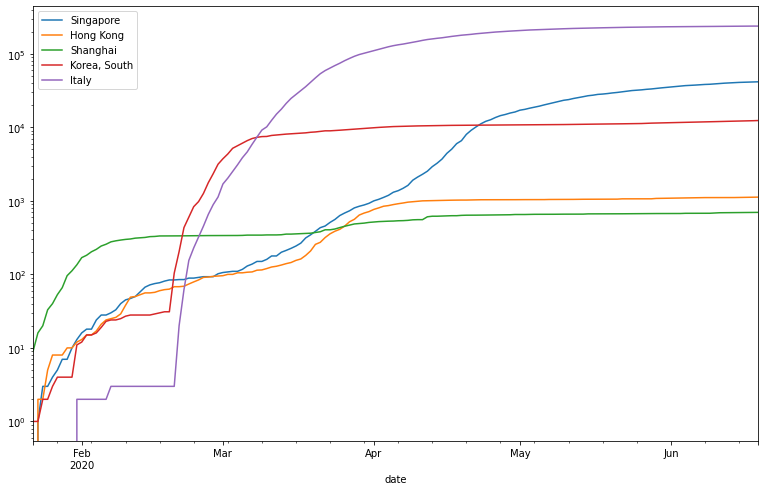

In [85]:
plot_data(south_asia, logy=True, figsize=(13, 8))

# North Europe

In [86]:
sweden = extract_data(df, "Sweden")

In [87]:
norway = extract_data(df, "Norway")

In [88]:
danemark = extract_data(df, 'Danemark')

In [89]:
finland = extract_data(df, 'Finland')

In [90]:
nl = extract_data(df, "Netherlands")

In [91]:
nort_eu = pd.concat([swiss, germany, sweden, norway, danemark, finland, nl], axis=1)

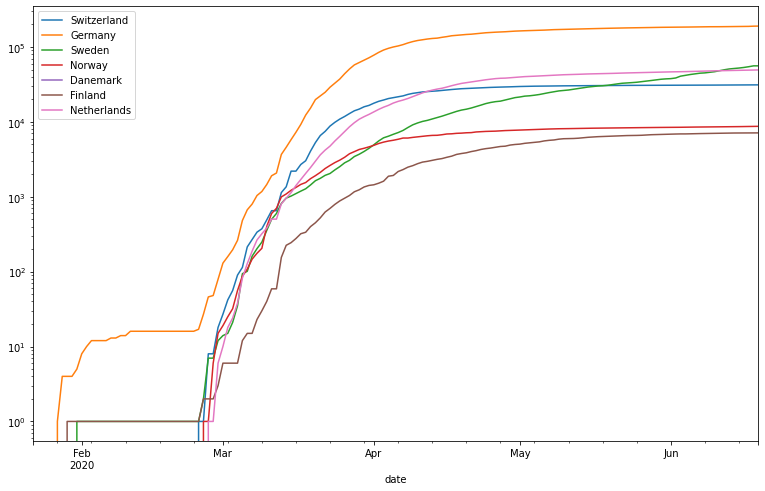

In [92]:
plot_data(nort_eu, logy=True, figsize=(13, 8))

# Death

In [93]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [94]:
death = pd.read_csv(url)

In [95]:
death.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  6/10/20  6/11/20  6/12/20  6/13/20  \
0        0        0        0  ...      405      426      446      451   
1        0        0        0  ...       34       35       36       36   
2        0        0        0  ...      732      741      751      760   
3        0        0        0  ...       51       51       51       51   
4        0        0        0  ...        4        5        5        6   

   6/14/20  6/15/20  6/16/20  6/17/20  6/18/20  6/19/20  
0      471      478      491      504      546      548  
1       36       36       37       38       39       42  
2      767      777      788      799      811      825  
3       51       51       52       52       52       52  
4        6        6        6        7        8        8  

[5 rows x 154 columns]

In [96]:
death.drop(columns=['Lat', 'Long'], inplace=True)

In [97]:
uk_death = extract_data(death, "United Kingdom")

In [98]:
us_death = extract_data(death, "US", groupby=True)

In [99]:
it_death = extract_data(death, "Italy")

In [100]:
es_death = extract_data(death, "Spain")

In [101]:
de_death = extract_data(death, "Germany")

In [102]:
cn_death = extract_data(death, "China", groupby=True)

In [103]:
fr_death = extract_data(death, "France")

In [104]:
ch_death = extract_data(death, "Switzerland")

In [105]:
comp_death = pd.concat([it_death, uk_death, us_death, es_death, de_death, cn_death, ch_death, fr_death], axis=1)

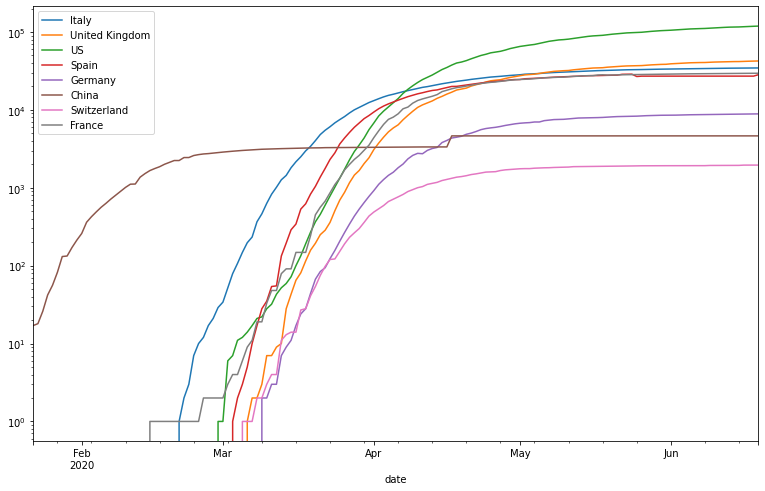

In [106]:
plot_data(comp_death, logy=True, figsize=(13, 8))

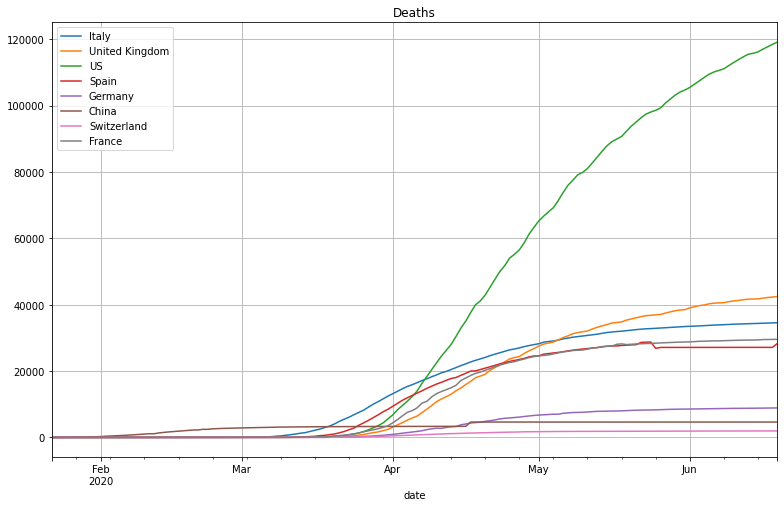

In [107]:
plot_data(comp_death, figsize=(13, 8), title="Deaths", grid=True)

In [108]:
world_death = death.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [109]:
world_death.index = pd.to_datetime(world_death.index)

In [110]:
world_death["day_of_year"] = world_death.index.dayofyear

In [111]:
world_death.reset_index(inplace=True)

In [112]:
world_death.columns = ["date", "world_death", "day_of_year"]

In [113]:
world_death.set_index(["date", "day_of_year"], inplace=True)

In [114]:
comp_world = add(world, world_death, "World")

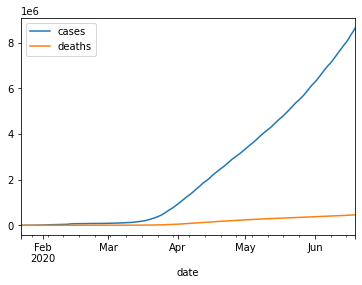

In [115]:
plot_data(comp_world[["cases", "deaths"]])

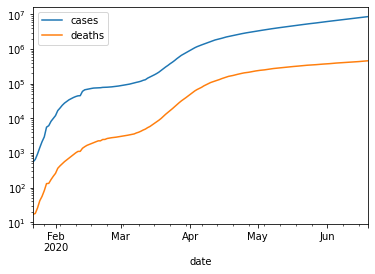

In [116]:
plot_data(comp_world[["cases", "deaths"]], logy=True)

In [117]:
comp_world["death_rate"] = comp_world["deaths"] / comp_world["cases"]

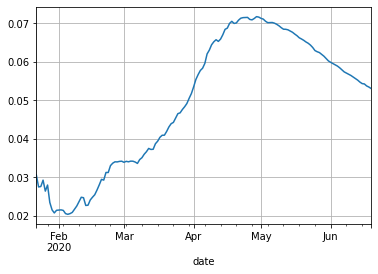

In [118]:
plot_data(comp_world["death_rate"], grid=True)

In [119]:
comp_world.to_excel(xl_writer, "World")

In [120]:
xl_writer.close()

In [121]:
df_summary_cases = pd.DataFrame(df[["Country/Region", df.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [122]:
df_summary_cases.columns = ["Country", "Cases"]

In [123]:
df_summary_deaths = pd.DataFrame(death[["Country/Region", death.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [124]:
df_summary_deaths.columns = ["Country", "Deaths"]

In [125]:
df_summary = pd.merge(df_summary_cases, df_summary_deaths, how="outer", on="Country")

In [126]:
iso_code = pd.read_csv("country_name_to_iso_code.csv")
iso_code.loc[iso_code["Country"] == "Namibia", "alpha-2"] = "NA"
iso_code[iso_code["Country"] == "Namibia"]

Unnamed: 0  Country alpha-2
150         152  Namibia      NA

In [127]:
df_summary = pd.merge(df_summary, iso_code, how="outer", on="Country")
df_summary.drop(columns=["Unnamed: 0", ], inplace=True)

In [128]:
df_summary.sort_values(by=["Cases",], ascending=False)

Country      Cases    Deaths alpha-2
174                   US  2220961.0  119112.0      US
23                Brazil  1032913.0   48954.0      BR
140               Russia   568292.0    7831.0      RU
79                 India   395048.0   12948.0      IN
178       United Kingdom   303285.0   42546.0      GB
..                   ...        ...       ...     ...
245               Tuvalu        NaN       NaN      TV
246  U.S. Virgin Islands        NaN       NaN      VI
247        United States        NaN       NaN      US
248              Vanuatu        NaN       NaN      VU
249      Wallis & Futuna        NaN       NaN      WF

[250 rows x 4 columns]

In [129]:
number_of_countries = 15

In [130]:
by_countries = df_summary.copy().drop(columns="alpha-2").set_index("Country")

In [131]:
by_countries.sort_values(by="Cases", ascending=False, inplace=True)

In [132]:
by_countries.head(25)

Cases    Deaths
Country                            
US              2220961.0  119112.0
Brazil          1032913.0   48954.0
Russia           568292.0    7831.0
India            395048.0   12948.0
United Kingdom   303285.0   42546.0
Spain            245575.0   28315.0
Peru             244388.0    7461.0
Italy            238011.0   34561.0
Chile            231393.0    4093.0
Iran             200262.0    9392.0
France           196083.0   29620.0
Germany          190299.0    8887.0
Turkey           185245.0    4905.0
Pakistan         171666.0    3382.0
Mexico           170485.0   20394.0
Saudi Arabia     150292.0    1184.0
Bangladesh       105535.0    1388.0
Canada           102314.0    8408.0
South Africa      87715.0    1831.0
Qatar             85462.0      93.0
China             84494.0    4638.0
Belgium           60476.0    9695.0
Colombia          60387.0    2046.0
Belarus           57333.0     337.0
Sweden            56043.0    5053.0

In [133]:
[by_countries.iloc[:number_of_countries].sum(), ]

[Cases     6593906.0
 Deaths     382401.0
 dtype: float64]

In [134]:
by_countries = pd.concat([
    by_countries.iloc[:number_of_countries],
    pd.DataFrame([by_countries.iloc[number_of_countries:].sum(), ])
]
)

In [135]:
by_countries.rename(index={0: 'others'}, inplace=True)

In [136]:
by_countries

Cases    Deaths
US              2220961.0  119112.0
Brazil          1032913.0   48954.0
Russia           568292.0    7831.0
India            395048.0   12948.0
United Kingdom   303285.0   42546.0
Spain            245575.0   28315.0
Peru             244388.0    7461.0
Italy            238011.0   34561.0
Chile            231393.0    4093.0
Iran             200262.0    9392.0
France           196083.0   29620.0
Germany          190299.0    8887.0
Turkey           185245.0    4905.0
Pakistan         171666.0    3382.0
Mexico           170485.0   20394.0
others          2069229.0   77604.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7feebb191450>,
      dtype=object)

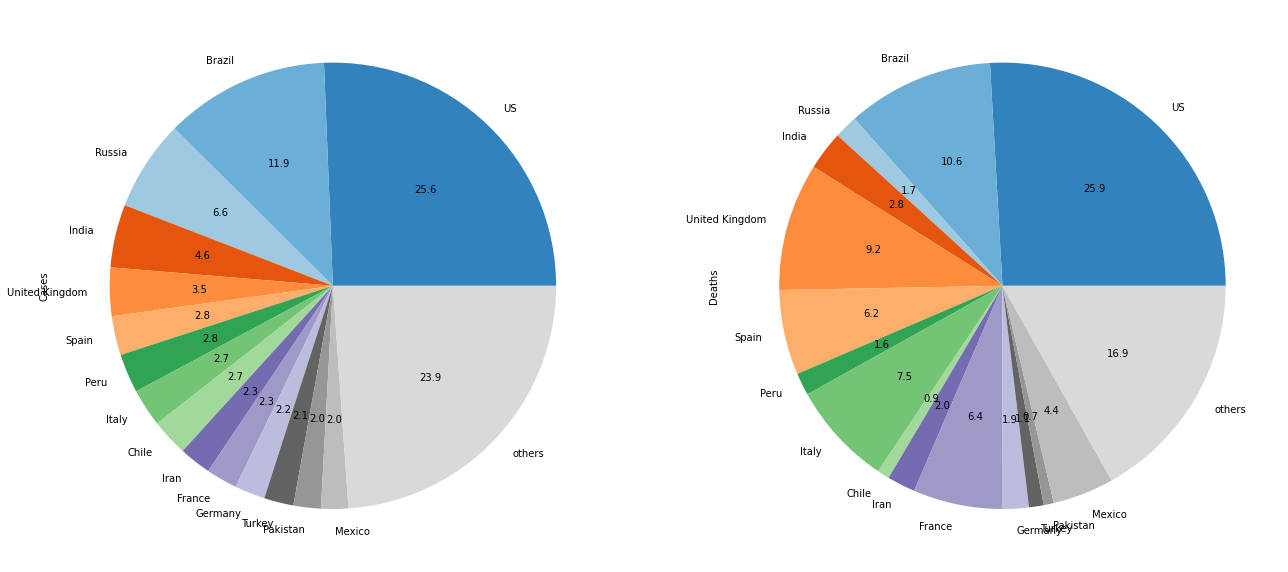

In [137]:
by_countries.plot.pie(subplots=True, figsize=(22, 11), cmap=plt.cm.get_cmap('tab20c'), legend=False, autopct='%.1f')

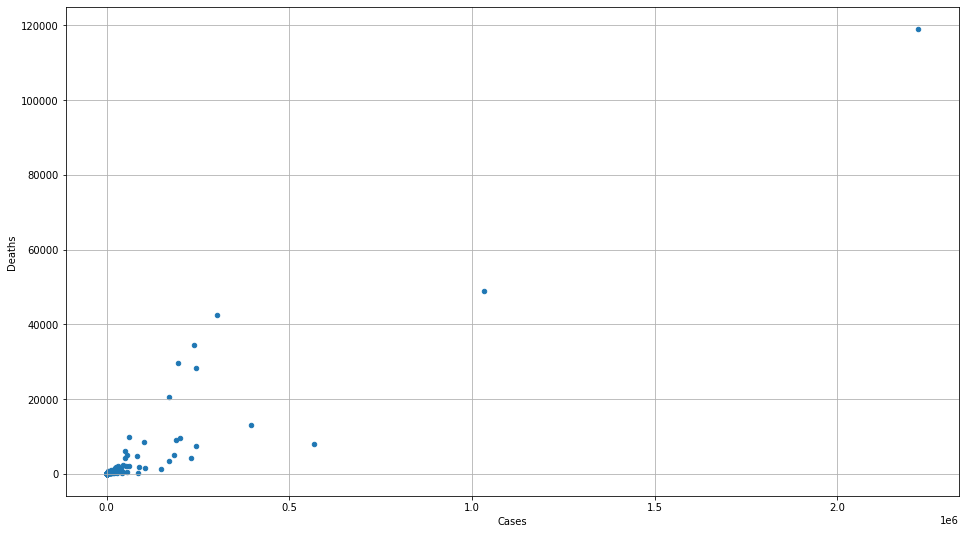

In [138]:
df_summary.plot.scatter(x="Cases", y="Deaths", figsize=(16, 9), grid=True)

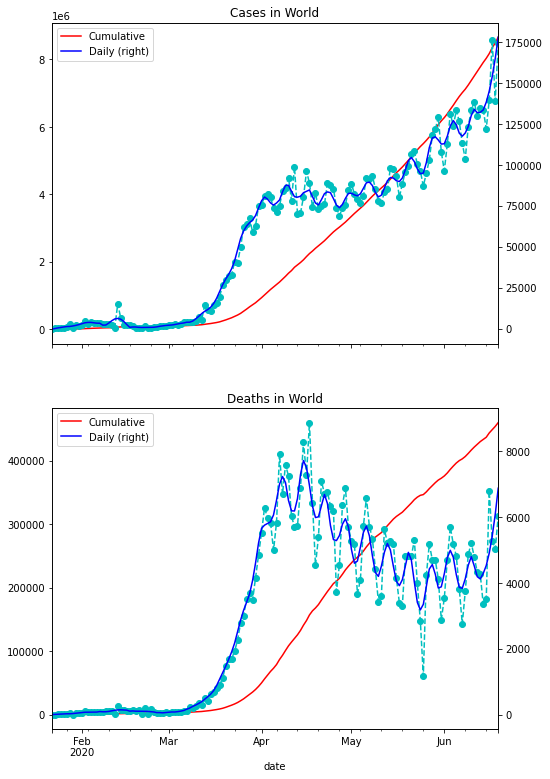

In [139]:
plot_daily(comp_world)

In [140]:
se = add(df, death, "Sweden")

In [141]:
uk = add(df, death, "United Kingdom")

In [142]:
it = add(df, death, "Italy")

In [143]:
sp = add(df, death, "Spain")

In [144]:
fr = add(df, death, "France")

In [145]:
ch = add(df, death, "Switzerland")

In [146]:
be = add(df, death, "Belgium")

In [147]:
de = add(df, death, "Germany")

In [148]:
kr = add(df, death, "Korea, South")

In [149]:
nl = add(df, death, "Netherlands")

In [150]:
us = add(df, death, "US")

In [151]:
sg = add(df, death, "Singapore")

In [152]:
br = add(df, death, "Brazil")

In [153]:
pe = add(df, death, "Peru")

In [154]:
ru = add(df, death, "Russia")

In [155]:
tu = add(df, death, "Turkey")

In [156]:
ir = add(df, death, "Iran")

In [157]:
ar = add(df, death, "Argentina")

In [158]:
mex = add(df, death, "Mexico")

In [159]:
chi = add(df, death, "Chile")

In [160]:
co = add(df, death, "Colombia")

In [161]:
india = add(df, death, "India")

In [162]:
pak = add(df, death, "Pakistan")

In [163]:
ind = add(df, death, "Indonesia")

In [164]:
dz = add(df, death, "Algeria")

In [165]:
mar = add(df, death, "Morocco")

In [166]:
# can = add(df, death, "Canada")

In [208]:
th = add(df, death, "Thailand")

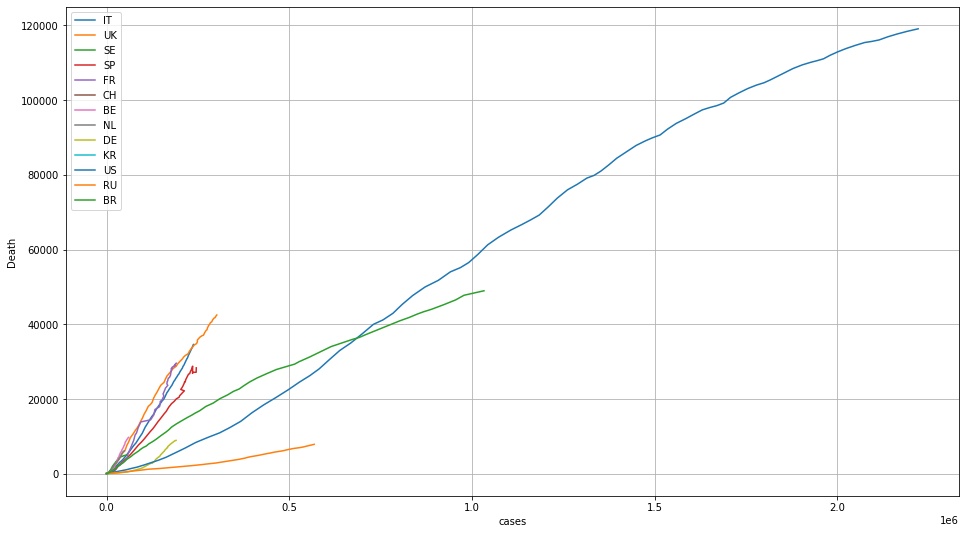

In [167]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylabel("Death")
it.plot(x="cases", y="deaths", ax=ax, grid=True, label="IT")
uk.plot(x="cases", y="deaths", ax=ax, grid=True, label="UK")
se.plot(x="cases", y="deaths", ax=ax, grid=True, label="SE")
sp.plot(x="cases", y="deaths", ax=ax, grid=True, label="SP")
fr.plot(x="cases", y="deaths", ax=ax, grid=True, label="FR")
ch.plot(x="cases", y="deaths", ax=ax, grid=True, label="CH")
be.plot(x="cases", y="deaths", ax=ax, grid=True, label="BE")
nl.plot(x="cases", y="deaths", ax=ax, grid=True, label="NL")
de.plot(x="cases", y="deaths", ax=ax, grid=True, label="DE")
kr.plot(x="cases", y="deaths", ax=ax, grid=True, label="KR")
us.plot(x="cases", y="deaths", ax=ax, grid=True, label="US")
ru.plot(x="cases", y="deaths", ax=ax, grid=True, label="RU")
br.plot(x="cases", y="deaths", ax=ax, grid=True, label="BR")

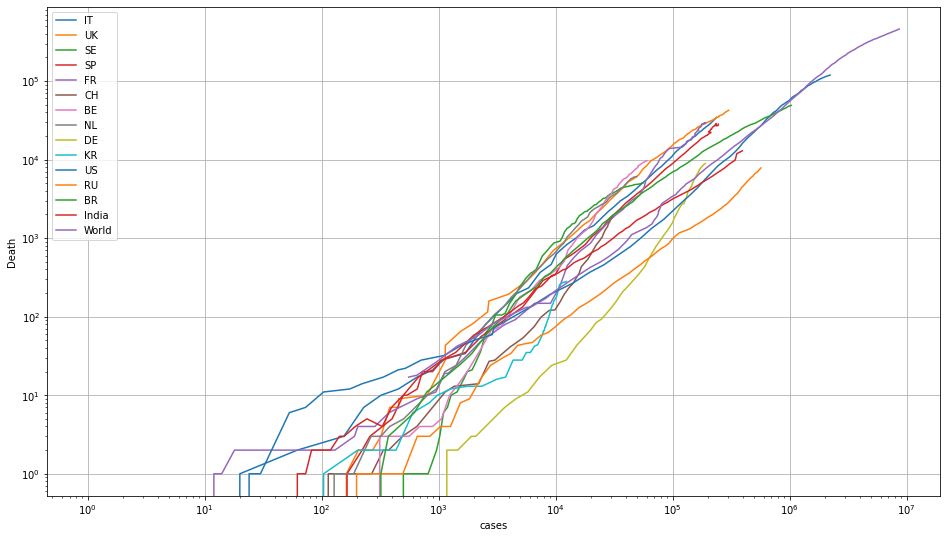

In [168]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylabel("Death")
it.plot(x="cases", y="deaths", ax=ax, grid=True, label="IT", loglog=True)
uk.plot(x="cases", y="deaths", ax=ax, grid=True, label="UK")
se.plot(x="cases", y="deaths", ax=ax, grid=True, label="SE")
sp.plot(x="cases", y="deaths", ax=ax, grid=True, label="SP")
fr.plot(x="cases", y="deaths", ax=ax, grid=True, label="FR")
ch.plot(x="cases", y="deaths", ax=ax, grid=True, label="CH")
be.plot(x="cases", y="deaths", ax=ax, grid=True, label="BE")
nl.plot(x="cases", y="deaths", ax=ax, grid=True, label="NL")
de.plot(x="cases", y="deaths", ax=ax, grid=True, label="DE")
kr.plot(x="cases", y="deaths", ax=ax, grid=True, label="KR")
us.plot(x="cases", y="deaths", ax=ax, grid=True, label="US")
ru.plot(x="cases", y="deaths", ax=ax, grid=True, label="RU")
br.plot(x="cases", y="deaths", ax=ax, grid=True, label="BR")
india.plot(x="cases", y="deaths", ax=ax, grid=True, label="India")
comp_world.plot(x="cases", y="deaths", ax=ax, grid=True, label="World")

In [169]:
by_countries.index

Index(['US', 'Brazil', 'Russia', 'India', 'United Kingdom', 'Spain', 'Peru',
       'Italy', 'Chile', 'Iran', 'France', 'Germany', 'Turkey', 'Pakistan',
       'Mexico', 'others'],
      dtype='object')

In [170]:
def plot_daily(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 13))
    dataframe = data.copy()
    dataframe.reset_index("day_of_year", drop=True, inplace=True)
    dataframe["cases"].plot(color="r", 
                            title=f"Cases in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax1)
    ax11 = dataframe["daily_cases"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax1)  
    dataframe["daily_cases_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax1)
    ax1.set_ylabel("Cumulative cases")
    ax11.set_ylabel("Daily Cases")
    #
    dataframe["deaths"].plot(color="r", 
                            title=f"Deaths in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax2)
    ax22 = dataframe["daily_death"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax2)  
    dataframe["daily_death_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax2)
    ax2.set_ylabel("Cumulative cases")
    ax22.set_ylabel("Daily deaths")

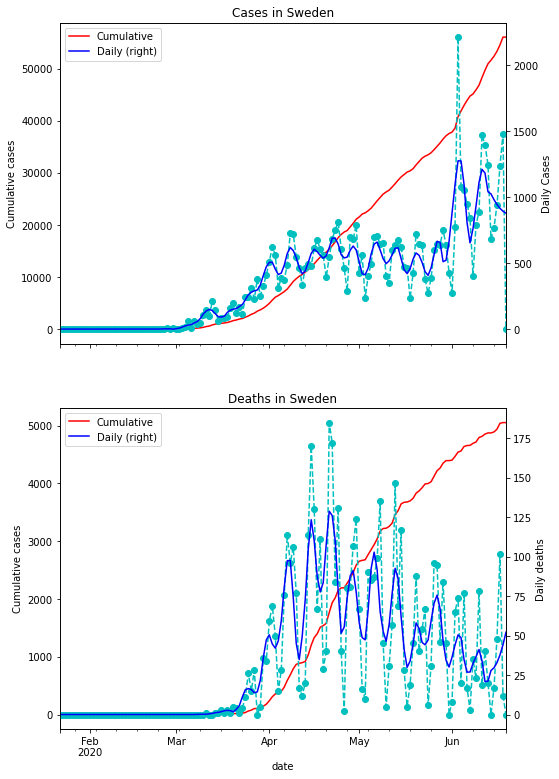

In [171]:
plot_daily(se)

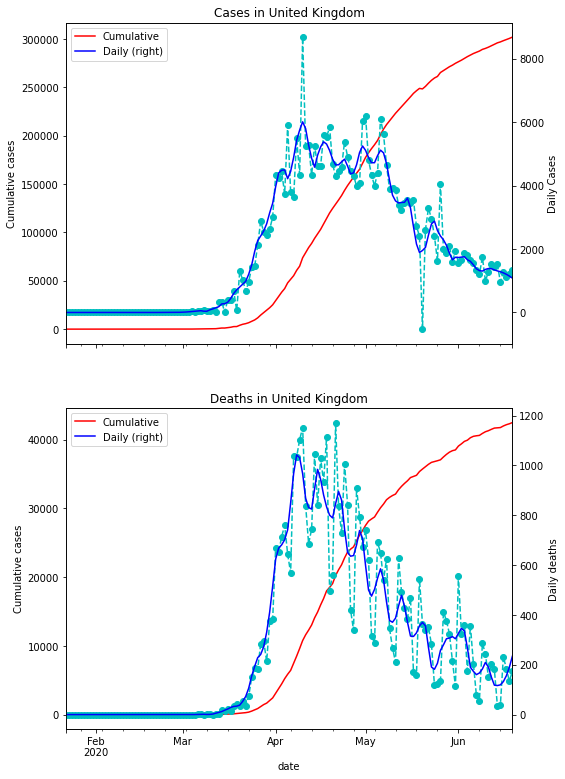

In [172]:
plot_daily(uk)

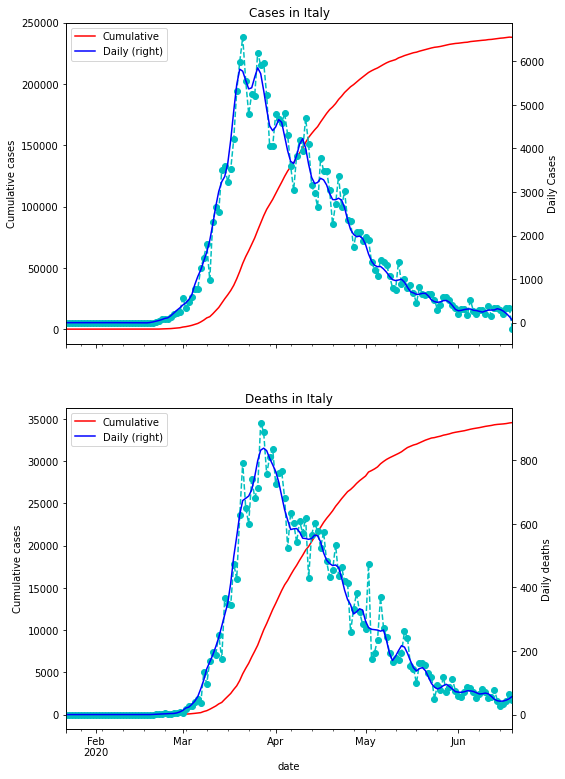

In [173]:
plot_daily(it)

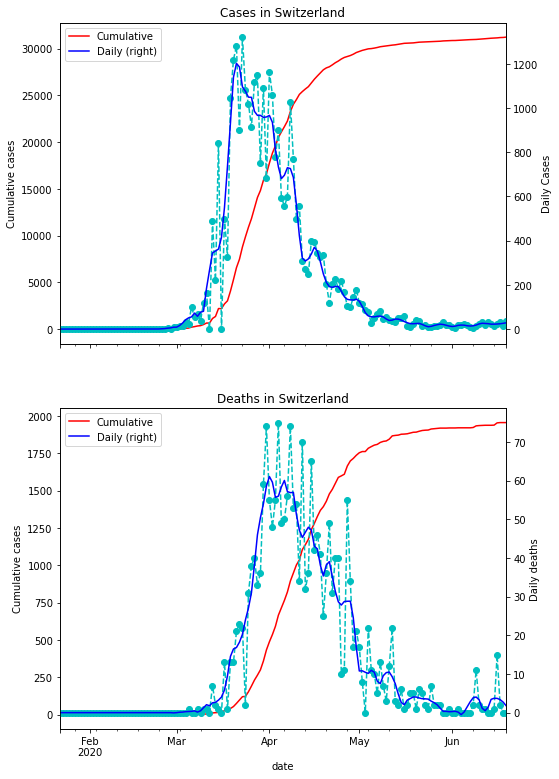

In [174]:
plot_daily(ch)

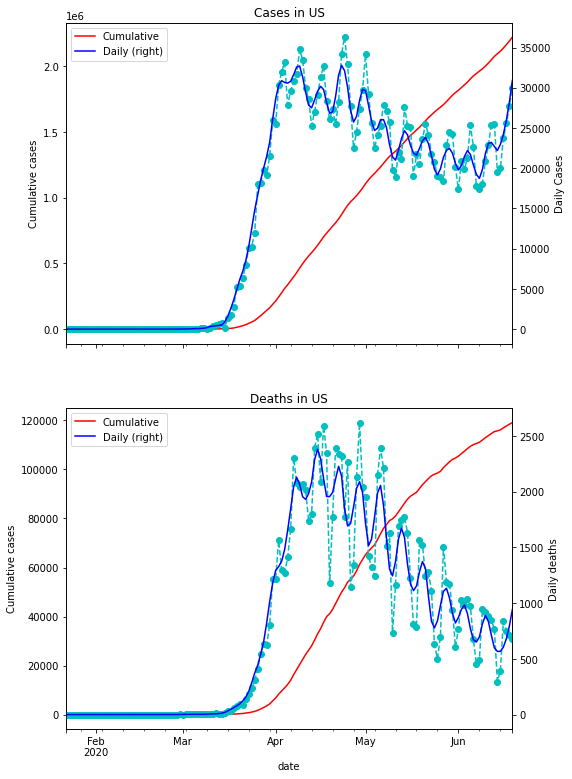

In [175]:
plot_daily(us)

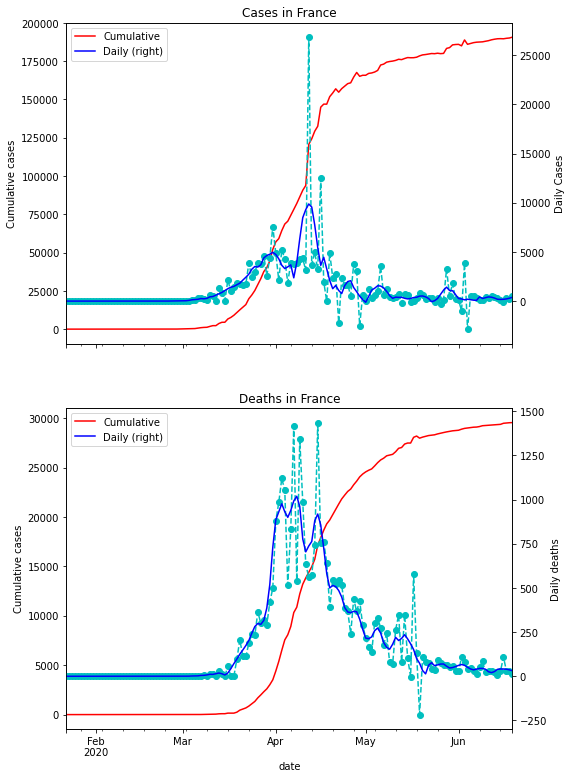

In [176]:
plot_daily(fr)

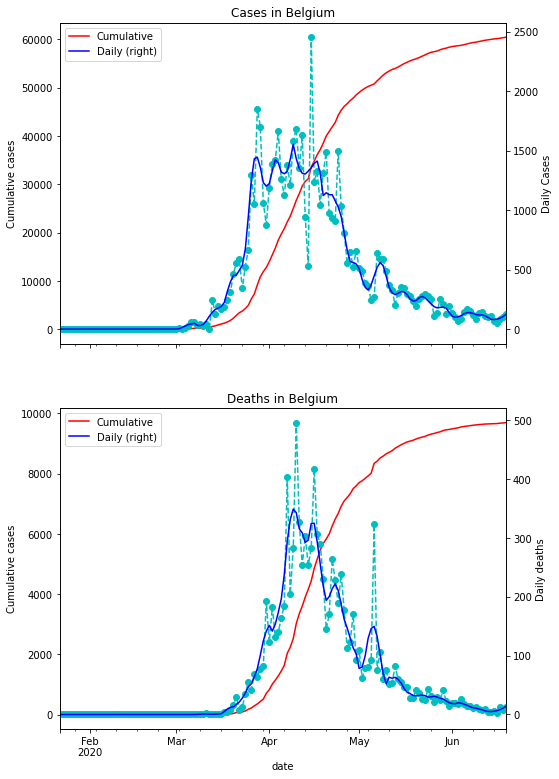

In [177]:
plot_daily(be)

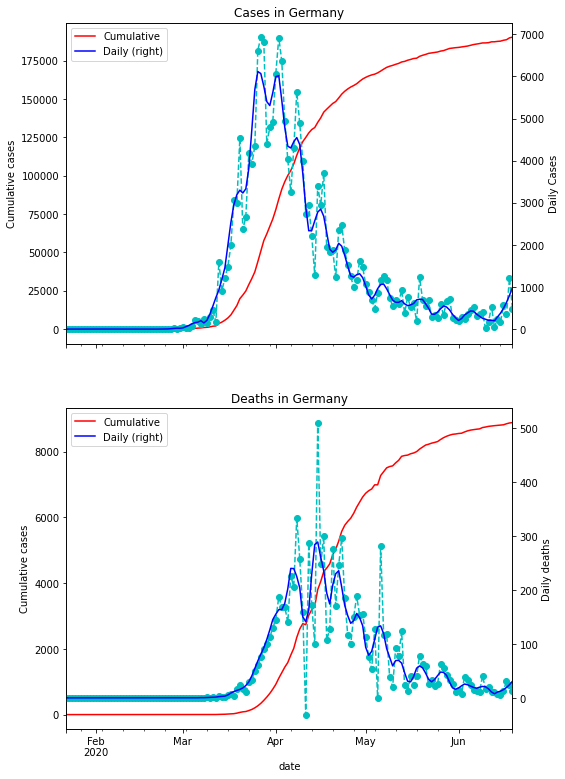

In [178]:
plot_daily(de)

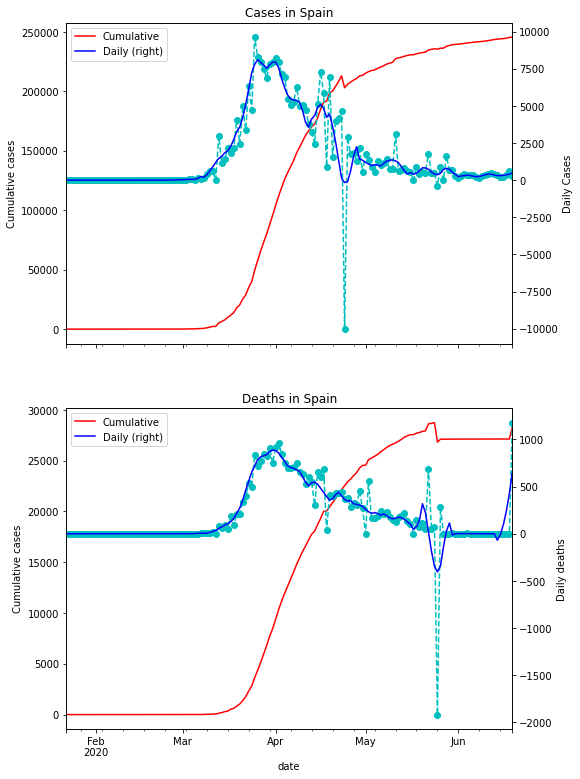

In [179]:
plot_daily(sp)

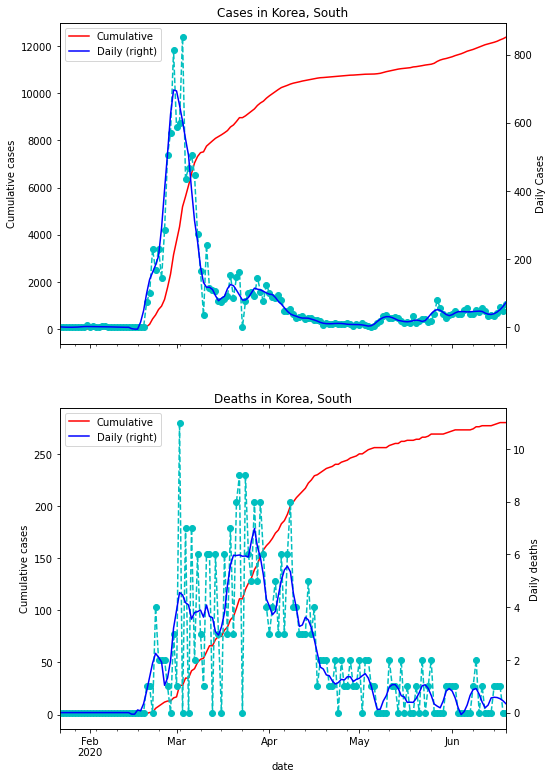

In [180]:
plot_daily(kr)

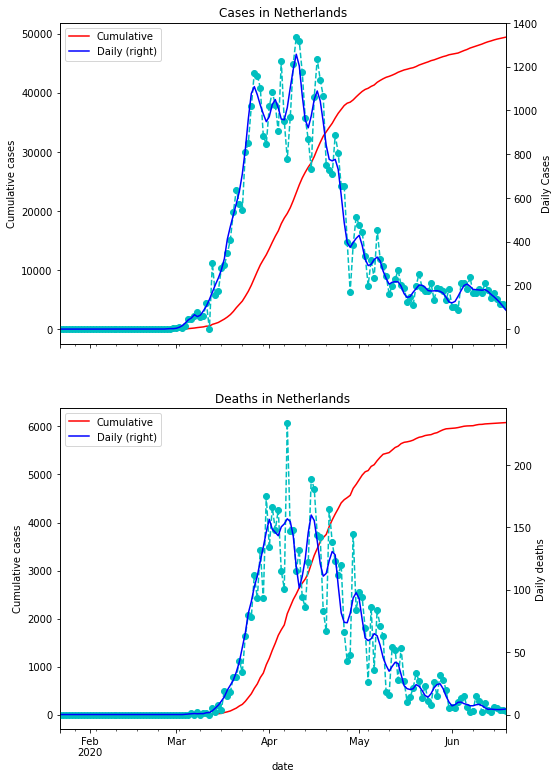

In [181]:
plot_daily(nl)

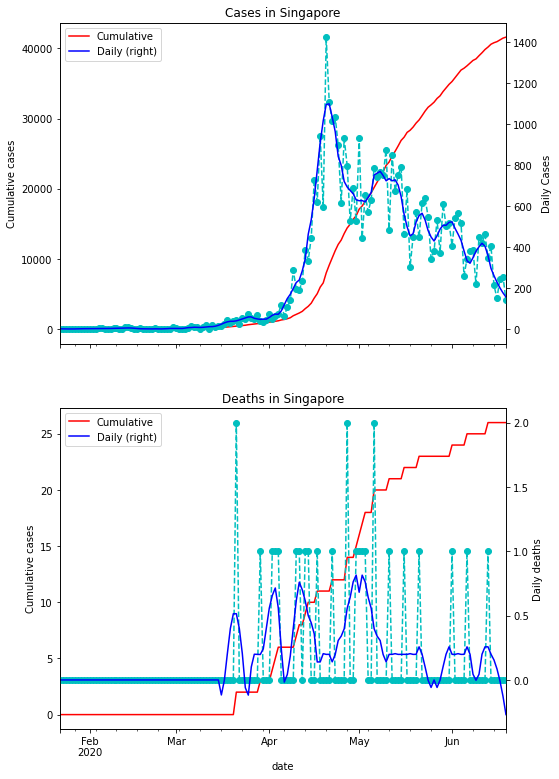

In [182]:
plot_daily(sg)

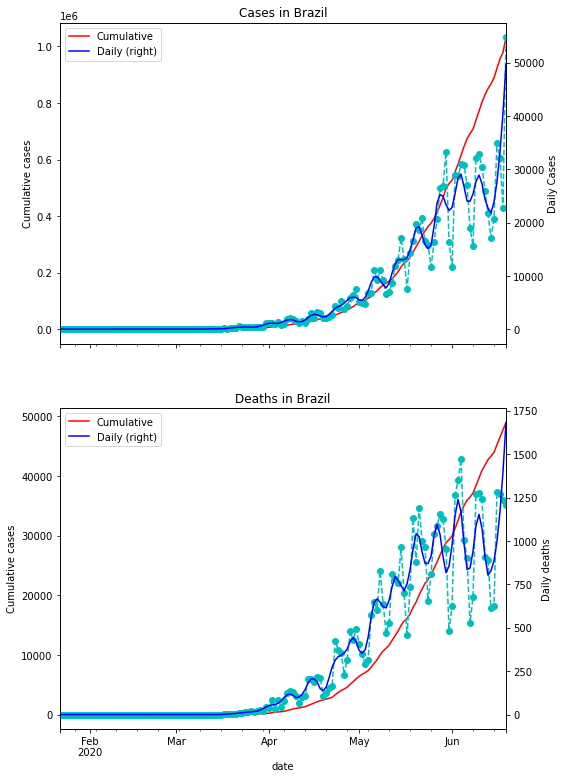

In [183]:
plot_daily(br)

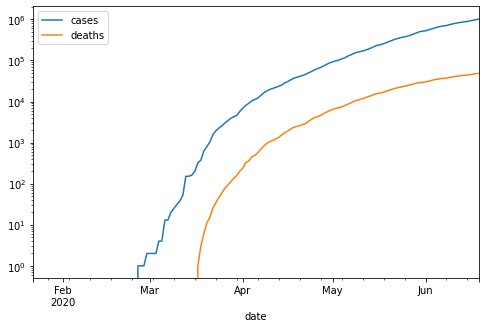

In [184]:
plot_data(br[["cases", "deaths"]], logy=True, figsize=(8, 5))

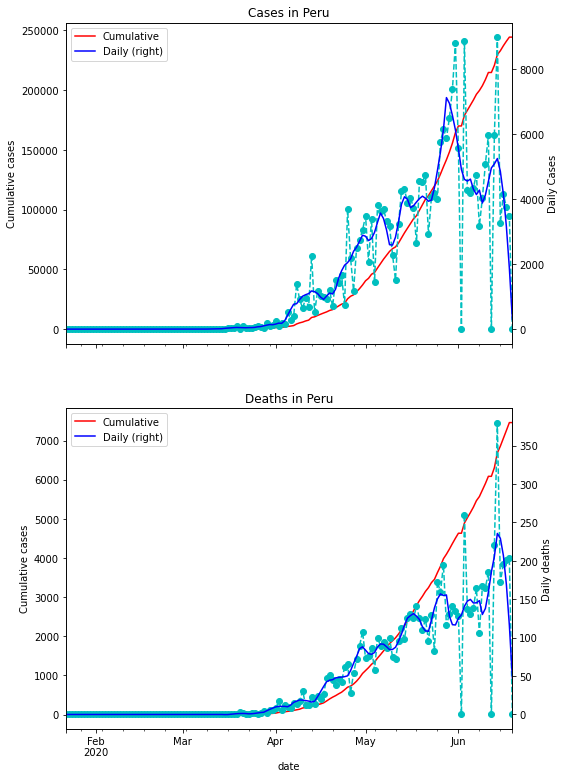

In [185]:
plot_daily(pe)

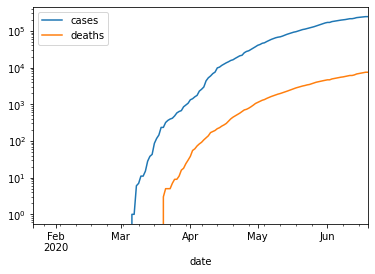

In [186]:
plot_data(pe[["cases", "deaths"]], logy=True)

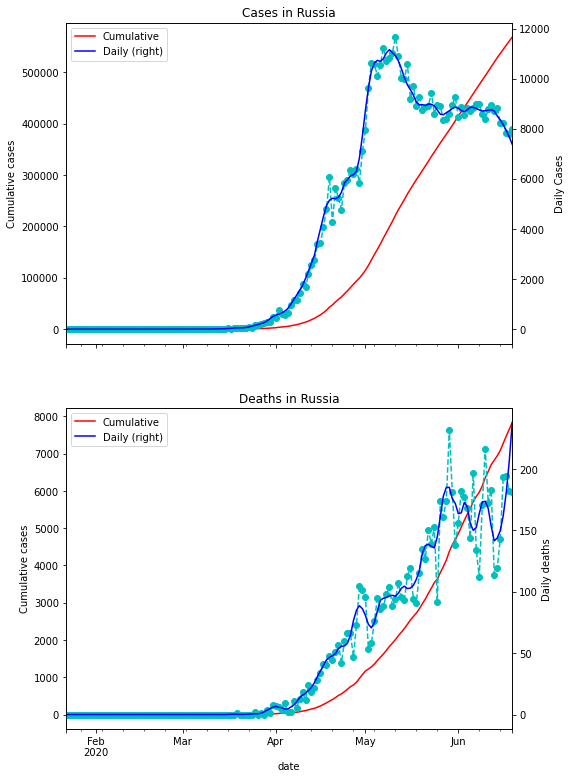

In [187]:
plot_daily(ru)

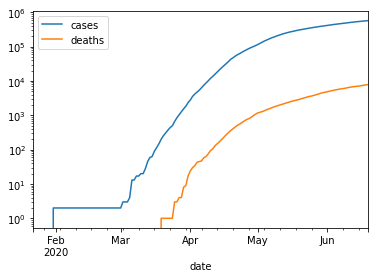

In [188]:
plot_data(ru[["cases", "deaths"]], logy=True)

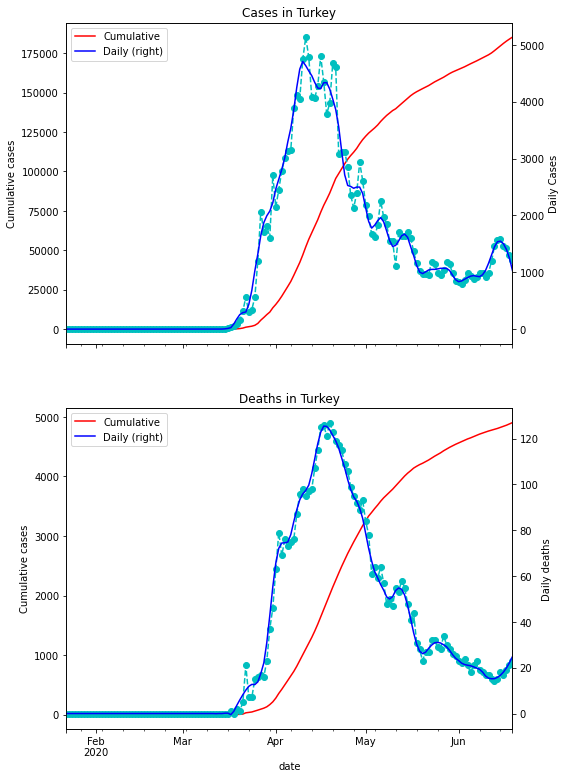

In [189]:
plot_daily(tu)

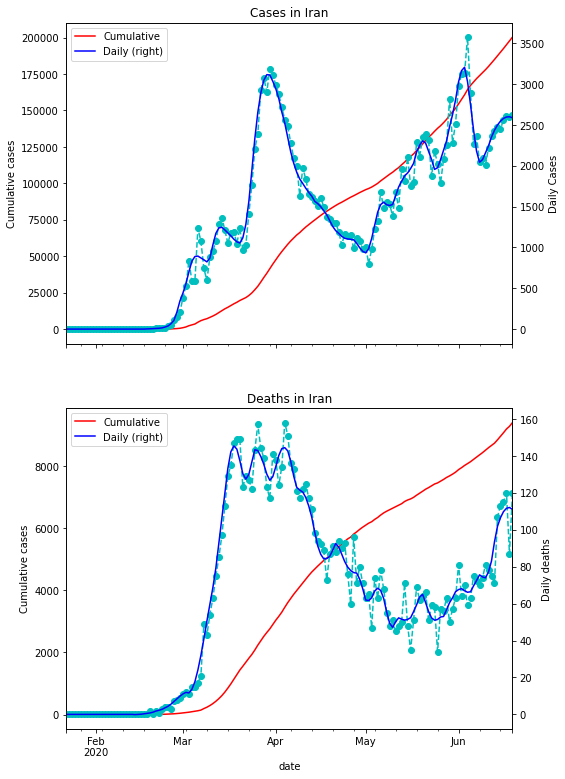

In [190]:
plot_daily(ir)

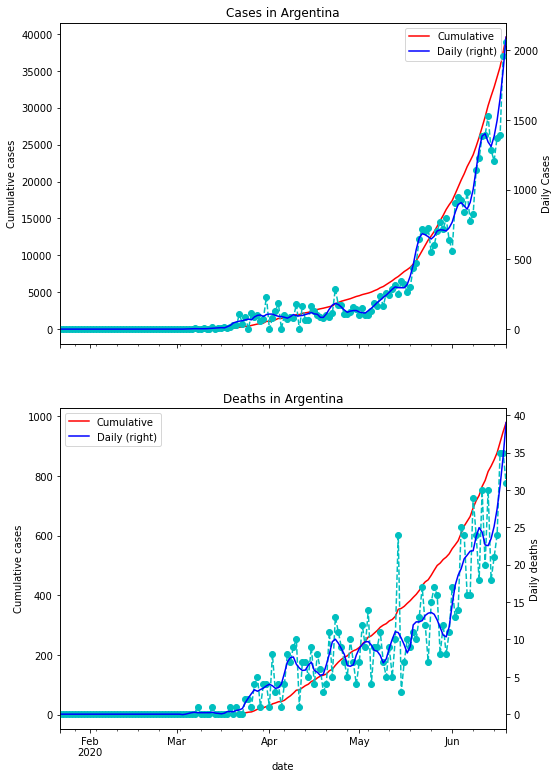

In [191]:
plot_daily(ar)

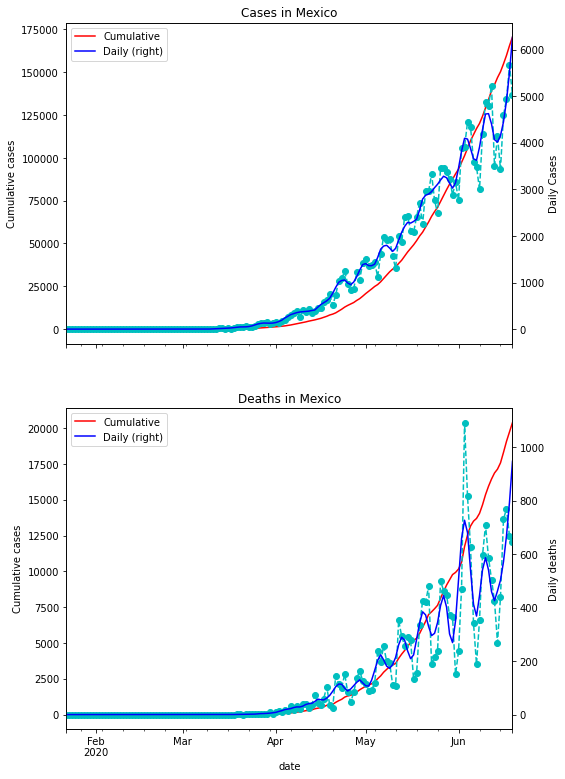

In [192]:
plot_daily(mex)

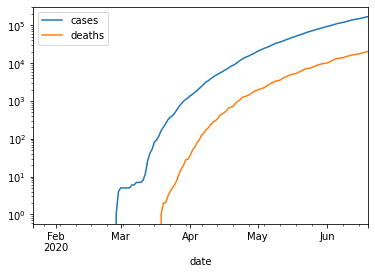

In [193]:
plot_data(mex[["cases", "deaths"]], logy=True)

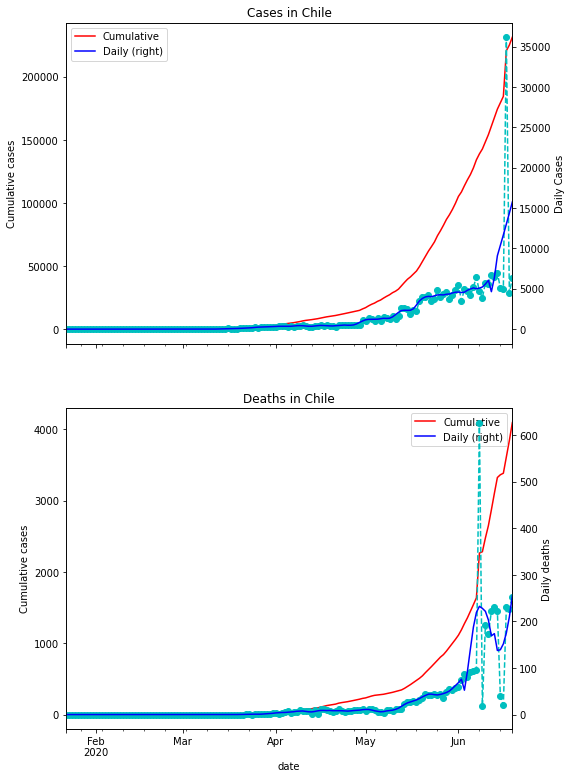

In [194]:
plot_daily(chi)

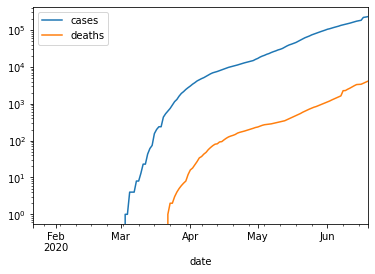

In [195]:
plot_data(chi[["cases", "deaths"]], logy=True)

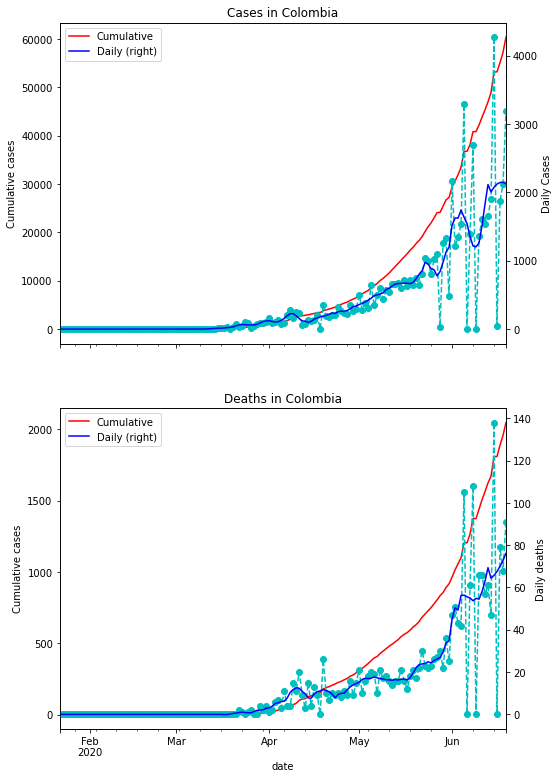

In [196]:
plot_daily(co)

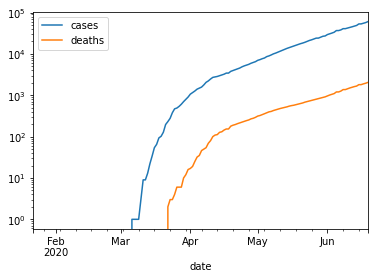

In [197]:
plot_data(co[["cases", "deaths"]], logy=True)

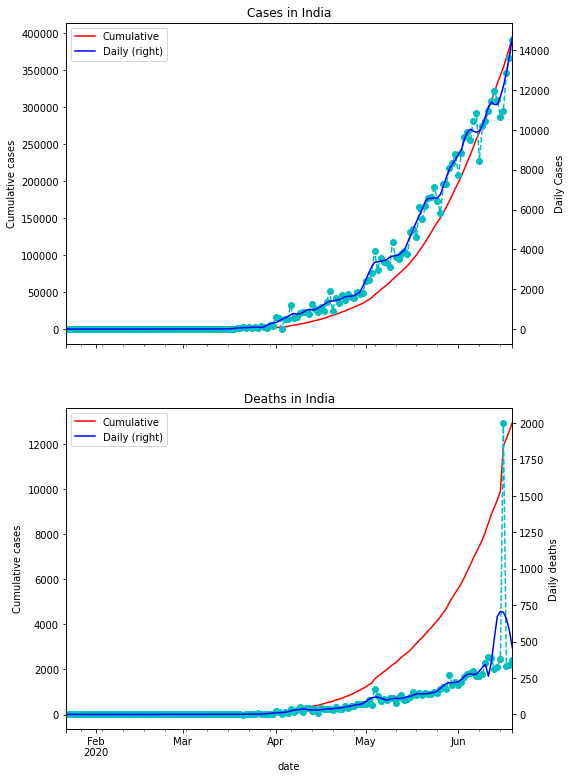

In [198]:
plot_daily(india)

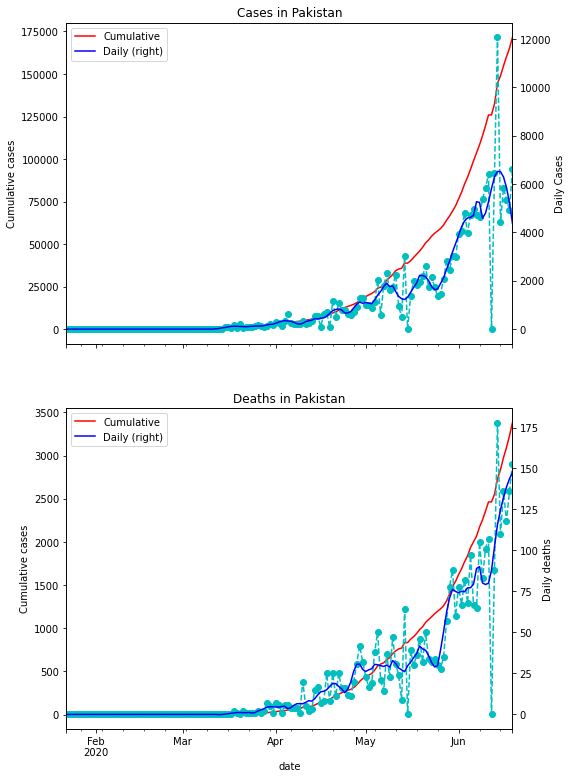

In [199]:
plot_daily(pak)

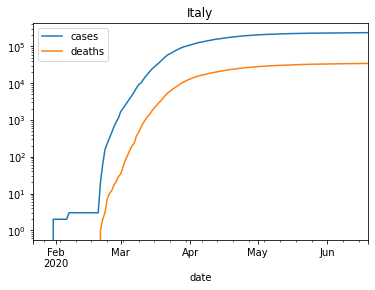

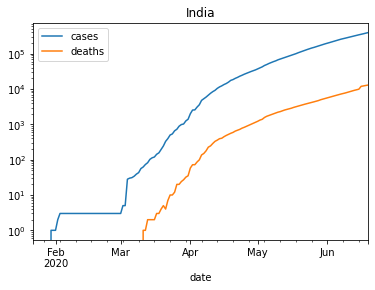

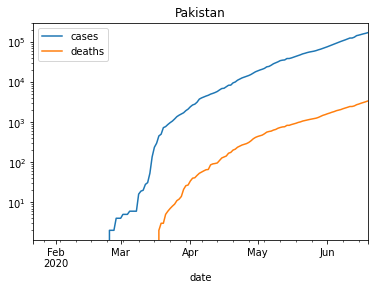

In [200]:
plot_data(it[["cases", "deaths"]], logy=True, title="Italy")
plot_data(india[["cases", "deaths"]], logy=True, title="India")
plot_data(pak[["cases", "deaths"]], logy=True, title="Pakistan")


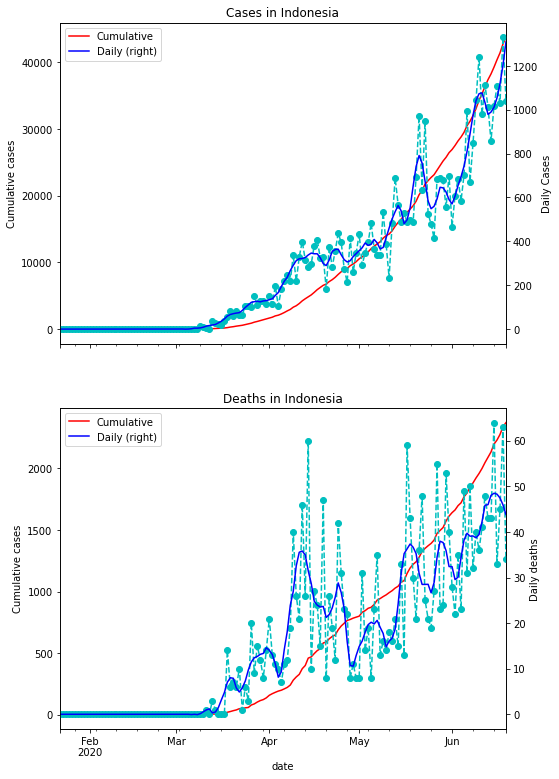

In [201]:
plot_daily(ind)

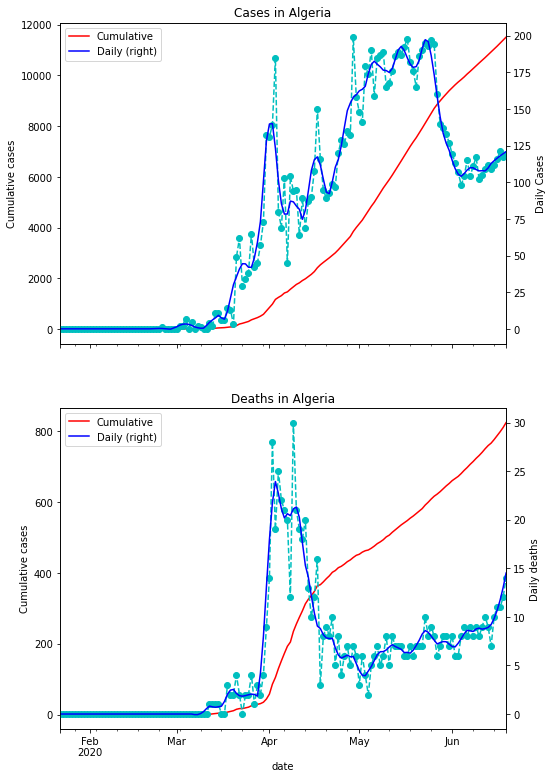

In [202]:
plot_daily(dz)

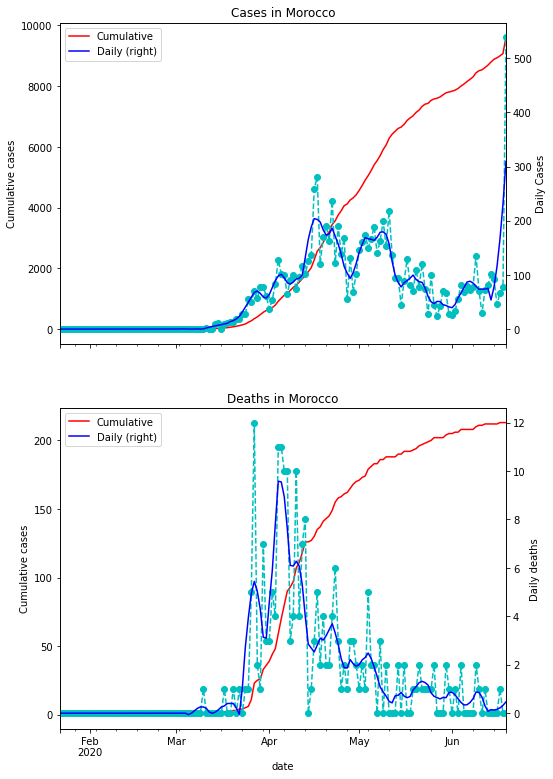

In [203]:
plot_daily(mar)

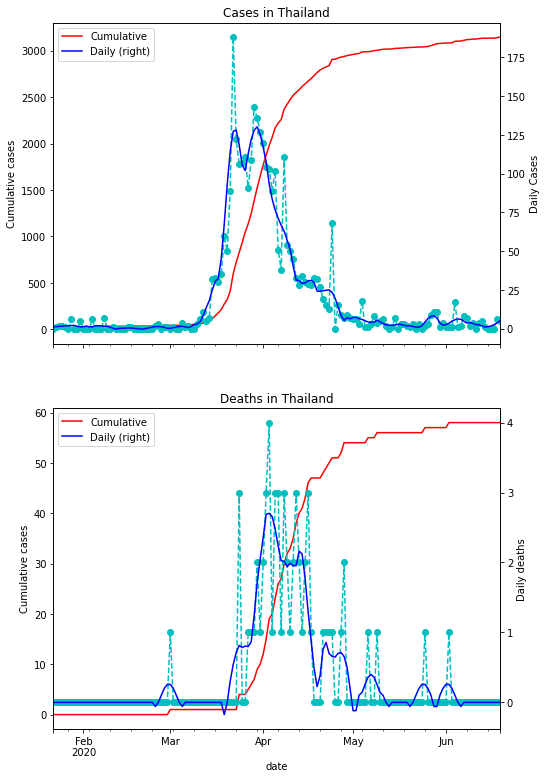

In [209]:
plot_daily(th)

In [204]:
se.tail(10)

cases  deaths  daily_cases  daily_cases_s  \
date       day_of_year                                              
2020-06-10 162          46814    4795        890.0    1112.347902   
2020-06-11 163          48288    4814       1474.0    1211.172300   
2020-06-12 164          49684    4854       1396.0    1183.212121   
2020-06-13 165          50931    4874       1247.0    1041.263598   
2020-06-14 166          51614    4874        683.0    1024.786908   
2020-06-15 167          52383    4891        769.0     981.254856   
2020-06-16 168          53323    4939        940.0     944.882479   
2020-06-17 169          54562    5041       1239.0     915.669775   
2020-06-18 170          56043    5053       1481.0     893.616744   
2020-06-19 171          56043    5053          0.0     878.723388   

                        daily_death  daily_death_s  
date       day_of_year                              
2020-06-10 162                 78.0      41.193473  
2020-06-11 163                 19.0      34.091492  
2020-06-12 164                 40.0      20.880925  
2020-06-13 165                 20.0      21.137335  
2020-06-14 166                  0.0      27.894911  
2020-06-15 167                 17.0      29.611111  
2020-06-16 168                 48.0      32.894911  
2020-06-17 169                102.0      37.746309  
2020-06-18 170                 12.0      44.165307  
2020-06-19 171                  0.0      52.151904

In [205]:
us.tail(15)

cases  deaths  daily_cases  daily_cases_s  \
date       day_of_year                                                
2020-06-05 157          1903854  109449      25311.0   21707.400738   
2020-06-06 158          1926538  110124      22684.0   20389.184926   
2020-06-07 159          1944309  110575      17771.0   19245.222611   
2020-06-08 160          1961781  111068      17472.0   18736.664724   
2020-06-09 161          1979868  112014      18087.0   19826.022339   
2020-06-10 162          2000702  112935      20834.0   21810.518842   
2020-06-11 163          2023590  113823      22888.0   23079.895105   
2020-06-12 164          2048986  114669      25396.0   23201.666667   
2020-06-13 165          2074526  115436      25540.0   22702.955711   
2020-06-14 166          2094058  115732      19532.0   22200.103924   
2020-06-15 167          2114026  116127      19968.0   22955.390054   
2020-06-16 168          2137731  116963      23705.0   24203.863831   
2020-06-17 169          2163290  117717      25559.0   25945.525253   
2020-06-18 170          2191052  118434      27762.0   28180.374320   
2020-06-19 171          2220961  119112      29909.0   30908.411033   

                        daily_death  daily_death_s  
date       day_of_year                              
2020-06-05 157                970.0     770.324981  
2020-06-06 158                675.0     670.601981  
2020-06-07 159                451.0     651.366939  
2020-06-08 160                493.0     697.184343  
2020-06-09 161                946.0     813.635198  
2020-06-10 162                921.0     889.310606  
2020-06-11 163                888.0     834.569930  
2020-06-12 164                846.0     711.535548  
2020-06-13 165                767.0     598.939005  
2020-06-14 166                296.0     566.692308  
2020-06-15 167                395.0     567.497669  
2020-06-16 168                836.0     605.414918  
2020-06-17 169                754.0     680.444056  
2020-06-18 170                717.0     792.585082  
2020-06-19 171                678.0     941.837995

In [206]:
it["death_rate"] = it["deaths"] / it["cases"]
ch["death_rate"] = ch["deaths"] / ch["cases"]
se["death_rate"] = se["deaths"] / se["cases"]
uk["death_rate"] = uk["deaths"] / uk["cases"]
be["death_rate"] = be["deaths"] / be["cases"]
sp["death_rate"] = sp["deaths"] / sp["cases"]
de["death_rate"] = de["deaths"] / de["cases"]
us["death_rate"] = us["deaths"] / us["cases"]

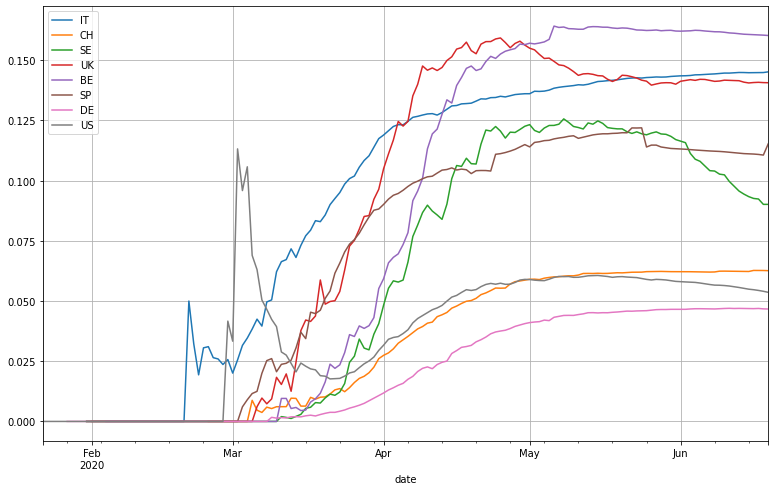

In [207]:
df_rate = pd.concat([it["death_rate"], 
                     ch["death_rate"], 
                     se["death_rate"], 
                     uk["death_rate"],
                     be["death_rate"],
                     sp["death_rate"],
                     de["death_rate"],
                     us["death_rate"],
                    ], axis=1)
df_rate.columns = ["IT", "CH", "SE", "UK", "BE", "SP", "DE", "US"]
df_rate.dropna()
ax =plot_data(df_rate, grid=True, figsize=(13, 8))
